<a href="https://colab.research.google.com/github/C00ldudeNoonan/Global_inflation_viz/blob/main/Euro_Inflation_Rates_since_2000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

Inflation Data: https://www.worldbank.org/en/research/brief/inflation-database

ShapeFiles: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-boundary-lines/ß

Data needs to be pivoted for Chart (do in excel)
Map Country Codes
Timelapse Plot, This time use gif maker within matplotlib

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 7.8 MB 21.7 MB/s 
     |████████████████████████████████| 16.6 MB 120 kB/s 


[4030570.03718928 2685041.71018844 4670922.21302215 3551502.59713124]


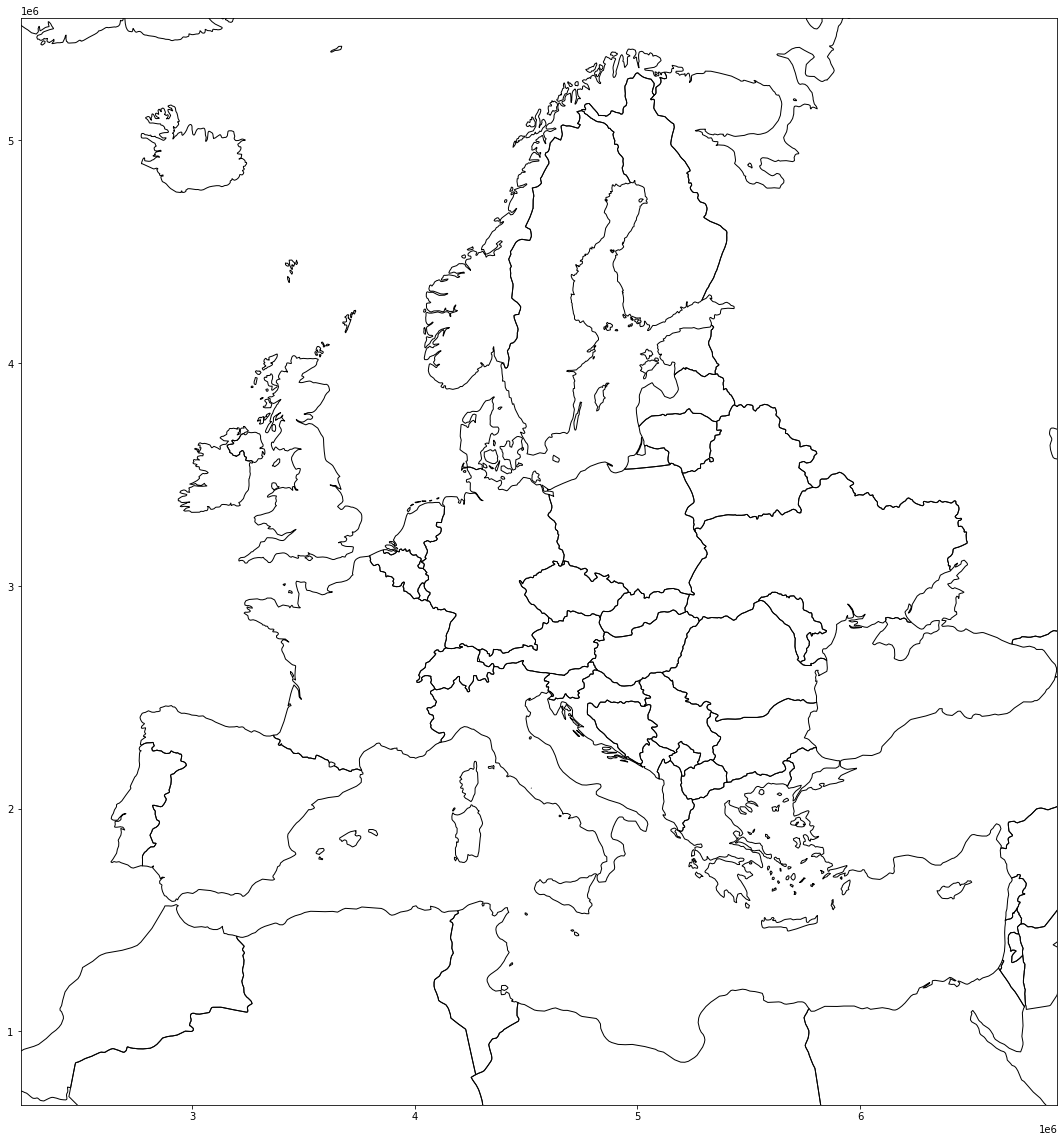

In [6]:
from shapely import geometry
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import imageio
import os
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# shapefiles import

CountryBoundaries = '/vsicurl/https://github.com/C00ldudeNoonan/Global_inflation_viz/raw/main/ne_50m_admin_0_countries.shp' 
CountryBoundaries = gpd.read_file(CountryBoundaries)
CountryBoundaries.crs = "EPSG:4326"
CountryBoundaries = CountryBoundaries.to_crs("EPSG:3035") 

mapCountryList = ["Germany", "United Kingdom", "France", "Italy",
                  "Spain", "Ukraine", "Poland", "Romania", "Netherlands",
                  "Belgium", "Czechia", "Greece", "Portugal", "Sweden",
                  "Hungary", "Belarus", "Austria", "Serbia", "Switzerland",
                  "Bulgaria", "Denmark", "Finland", "Slovakia", "Norway",
                  "Ireland", "Croatia", "Moldova", "Bosnia and Herzegovina",
                  "Albania", "Lithuania", "North Macedonia", "Slovenia",
                  "Latvia", "Estonia", "Montenegro", "Luxembourg", "Malta", 
                  "Iceland", "Turkey", "Egypt", "Jordan", "Syria", "Israel",
                  "Cyprus", "Algeria", "Morocco", "Libya", "Tunisia", "Russia"
                  ,"Georgia", "Lebanon", 'North Cyprus', "Republic of Serbia",
                  "Kosovo"
                  ]

euro_df = CountryBoundaries[CountryBoundaries['SOVEREIGNT'].isin(mapCountryList)]
fig  = plt.figure(constrained_layout=False, figsize=(60, 20))
ax = fig.add_subplot()
aoi_bounds = euro_df[euro_df['SOVEREIGNT']=='Germany'].geometry.total_bounds
print(aoi_bounds)
plot_bounds = [aoi_bounds[0]-1800000, aoi_bounds[1]+4200000, aoi_bounds[2]-4000000, aoi_bounds[3]+2000000 ]
ax.set_xlim([plot_bounds[0], plot_bounds[1]])
ax.set_ylim([plot_bounds[2], plot_bounds[3]])

euro_df.boundary.plot(ax=ax, color='black', linewidth=1 )
plt.show()

<ipython-input-7-d327f0b48e43>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeadlineInfaltionSubset[str(numCols[index+1])+"_pct_change"] = (HeadlineInfaltionSubset[str(numCols[index+1])] - HeadlineInfaltionSubset[str(numCols[index])])/HeadlineInfaltionSubset[str(numCols[index])]


['Aruba', 'Afghanistan', 'Angola', 'Albania', 'United Arab Emirates', 'Argentina', 'Armenia', 'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas', 'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Botswana', 'Central African Republic', 'Canada', 'Switzerland', 'Chile', 'China', "CÃ´te d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Cayman Islands', 'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt, Arab Rep.', 'Spain', 'Estonia', 'Ethiopia', 'Finland', 'Fiji', 'France', 'Micronesia, Fed. Sts.', 'Gabon', 'United Kingdom', 'Georgia', 'Ghana', 'Guinea', 'Gambia, The', 'Guinea-Bissau', 'Equatorial Guinea', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hong Kong SAR, China', 'Honduras', 'Croatia

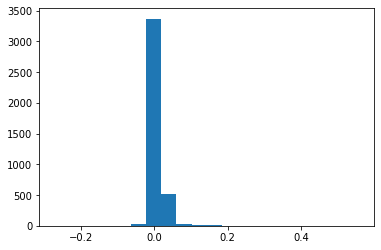

In [7]:
# csv transformation
HeadlineInfaltionQuarterly = pd.read_csv("https://raw.githubusercontent.com/C00ldudeNoonan/Global_inflation_viz/main/Headline_inflation_quarterly.csv")

HeadlineInfaltionSubset = HeadlineInfaltionQuarterly[HeadlineInfaltionQuarterly['Country'].isin(mapCountryList)]
numCols = [int(col) for col in HeadlineInfaltionSubset if col.startswith('2')]

# % change calculation between columns loop on filtercolumn list
for col in numCols:
  index = numCols.index(col)
  if col== numCols[-1]:
    pass
  else:
    HeadlineInfaltionSubset[str(numCols[index+1])+"_pct_change"] = (HeadlineInfaltionSubset[str(numCols[index+1])] - HeadlineInfaltionSubset[str(numCols[index])])/HeadlineInfaltionSubset[str(numCols[index])]

# getting all columns for wide to long pivot
filter_col = [col for col in HeadlineInfaltionSubset if col.endswith('_pct_change') or col =='Country']

HeadlineInfaltionSubset = HeadlineInfaltionSubset[filter_col]
HeadlineInfaltionPivot = pd.melt(HeadlineInfaltionSubset
                                 ,id_vars=["Country"]
                                 ,value_vars=[col for col in HeadlineInfaltionSubset if col.startswith('2')]
                                 ,var_name='Quarter'
                                 ,value_name='HeadlineInflation')
HeadlineInfaltionPivot["Quarter"] = HeadlineInfaltionPivot["Quarter"].apply(lambda x: x.replace("_pct_change", ""))
HeadlineInfaltionPivot = HeadlineInfaltionPivot.astype({"Quarter": int, "HeadlineInflation": float})

print(list(HeadlineInfaltionQuarterly['Country'].unique()))
# replace country value 'Czech Republic':'Czechia', 'Russian Federation': 'Russia', 'Egypt, Arab Rep.':'Egypt'
HeadlineInfaltionPivot["Country"] = HeadlineInfaltionPivot["Country"].apply(lambda x: x.replace("Czech Republic", "Czechia"))
HeadlineInfaltionPivot["Country"] = HeadlineInfaltionPivot["Country"].apply(lambda x: x.replace("Russian Federation", "Russia"))
HeadlineInfaltionPivot["Country"] = HeadlineInfaltionPivot["Country"].apply(lambda x: x.replace("Egypt, Arab Rep.", "Egypt"))

print(HeadlineInfaltionPivot.head())

plt.hist(HeadlineInfaltionPivot['HeadlineInflation'], bins=20)
plt.show()


In [93]:
from threading import currentThread



def plot_frame(period):
  
  # subsetting and merging data frames
  plotdf = HeadlineInfaltionPivot[HeadlineInfaltionPivot['Quarter']==period]
  plotdf = euro_df.merge(plotdf, how='left', right_on='Country',left_on='SOVEREIGNT')
  plotdf = GeoDataFrame(plotdf)
   

  currentProgress = int(plotdf['Quarter'].min()-HeadlineInfaltionPivot['Quarter'].min())
  remainingTime = int(HeadlineInfaltionPivot['Quarter'].max()-HeadlineInfaltionPivot['Quarter'].min()) - currentProgress
  progressDf = pd.DataFrame({'currentProgress': [currentProgress], 'remainingTime': [remainingTime]})


  fig  = plt.figure(constrained_layout=False, figsize=(30, 15))
  gs1 = fig.add_gridspec(nrows=4, ncols=7, hspace=0.1)
  fig_ax1 = fig.add_subplot(gs1[0:3,:])
  fig_ax2 = fig.add_subplot(gs1[-1,3:6])

  # Limits

  #ax = plt.axes()


  # COLOR SCALES
  # vaporwave color pallete
  cmap = matplotlib.colors.ListedColormap([ '#090C58','#3C1053', '#4AC9E3'
                                            , '#43aa8b', '#F4AF23', '#E10098'
                                          ])
  bounds = np.array([-0.4,-0.04, 0, 0.02, 0.04, 0.4])
  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=7)

  # plot bounds centered on Europe
  aoi_bounds = euro_df[euro_df['SOVEREIGNT']=='Germany'].geometry.total_bounds
  plot_bounds = [aoi_bounds[0]-1800000, aoi_bounds[1]+4200000, aoi_bounds[2]-4000000, aoi_bounds[3]+2000000 ]
  fig_ax1.set_xlim([plot_bounds[0], plot_bounds[1]])
  fig_ax1.set_ylim([plot_bounds[2], plot_bounds[3]])

  fig_ax1.set_title('Inflation By Country : ' + str(period)[:-1] + "-Q"+ str(period)[-1], fontsize=26, weight='bold', color="black")

  plotdf.plot(ax=fig_ax1
              , column='HeadlineInflation'
              , cmap=cmap
              , edgecolor="black"
              , norm=norm
              , legend=True
              ,missing_kwds={"color": "#ffecc4",
                             "edgecolor": "black",
                             "hatch": "///",
                             "label": "Missing values",
              },)
  
  # progress bar subplot
  progressDf.plot(ax=fig_ax2, kind = 'barh',stacked = True,mark_right = True, color=['#934add', '#7998EE'],legend=False)
  fig_ax2.set_title('Progress Bar' , fontsize=18, weight='bold', color="black",y=-100, pad=-50)

  # save image
  plt.rcParams['axes.facecolor'] = '#D7A9E3'
  filename = str(period) + ".png"
  fig_ax2.axis('off')
  fig_ax1.axis('off')
  plt.savefig(filename, bbox_inches='tight', facecolor='#D7A9E3')
  plt.close()

  return filename

#plot_frame(20054)

'20054.png'

In [94]:
%%time
filenames = []

# loop through and saving gifs for each period
for period in list(HeadlineInfaltionPivot["Quarter"].unique()):
  filenames.append(plot_frame(period))

# build gif
with imageio.get_writer('Inflation_timelapse.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        imageframe2 = image
        writer.append_data(image)
        writer.append_data(imageframe2)

# Remove files
for filename in set(filenames):
    os.remove(filename)

CPU times: user 1min 29s, sys: 38.7 s, total: 2min 7s
Wall time: 1min 27s
